In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))  # add project root

import pandas as pd
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

from pipelines.pipeline_runner import run_full_pipeline_with_split  
from utils.ml_utils import prepare_X_y  

plt.style.use("seaborn-v0_8-whitegrid")


In [ ]:
# Run leakage-safe pipeline with Stage0 → Stage1 → Stage2 → split → Stage3Fitter
dfs = run_full_pipeline_with_split()

df_raw    = dfs["raw"]
df_stage1 = dfs["stage1"]
df_stage2 = dfs["stage2"]

df_train = dfs["train"]
df_val   = dfs["val"]
df_test  = dfs["test"]

# Optional: save train/val/test Stage 3 datasets
df_train.to_csv("../data/clean/train_stage3.csv", index=False)
df_val.to_csv("../data/clean/val_stage3.csv", index=False)
df_test.to_csv("../data/clean/test_stage3.csv", index=False)


Shapes:
raw      : (22306, 67)
stage1   : (22306, 72)
stage2   : (21472, 66)
train S3 : (15030, 87)
val S3   : (3221, 87)
test S3  : (3221, 87)


In [6]:
def evaluate_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"===== {name} =====")
    print(f"MAE: {mae:,.2f}")
    print(f"R² : {r2:.4f}")
    return mae, r2


def plot_regression_diagnostics(y_true, y_pred, title_prefix="Model"):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1) Actual vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.4)
    min_v = min(y_true.min(), y_pred.min())
    max_v = max(y_true.max(), y_pred.max())
    axes[0].plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
    axes[0].set_title(f"{title_prefix} — Actual vs Predicted")
    axes[0].set_xlabel("Actual Price")
    axes[0].set_ylabel("Predicted Price")

    # 2) Residual Distribution
    sns.histplot(residuals, kde=True, bins=40, ax=axes[1], color="steelblue")
    axes[1].set_title(f"{title_prefix} — Residual Distribution")
    axes[1].set_xlabel("Residual (Actual - Predicted)")

    # 3) Residuals vs Predicted
    axes[2].scatter(y_pred, residuals, alpha=0.4)
    axes[2].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[2].set_title(f"{title_prefix} — Residuals vs Predicted")
    axes[2].set_xlabel("Predicted Price")
    axes[2].set_ylabel("Residual")

    plt.tight_layout()
    plt.show()


def plot_lr_feature_importance(model, feature_names, top_n=20, title="LR Coefficients"):
    """
    model: fitted LinearRegression (from pipeline.named_steps["model"])
    feature_names: list/Index of feature names (X.columns)
    """
    coefs = model.coef_
    features = np.array(feature_names)

    idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    top_features = features[idx]
    top_coefs = coefs[idx]

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_coefs)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.tight_layout()
    plt.show()


def plot_tree_importances(model, feature_names, top_n=30, title="Random Forest — Feature Importances"):
    importances = model.feature_importances_
    features = np.array(feature_names)
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


Shapes (LR):
X_train: (15030, 73)  y_train: (15030,)
X_val  : (3221, 73)  y_val  : (3221,)
X_test : (3221, 73)  y_test : (3221,)

NaNs in X_train (before imputer): 0

--- Linear Regression (Train) ---
===== LR — Train =====
MAE: 86,597.79
R² : 0.6358

--- Linear Regression (Validation) ---
===== LR — Validation =====
MAE: 87,064.55
R² : 0.6028

--- Linear Regression (Test) ---
===== LR — Test =====
MAE: 89,433.30
R² : 0.6239


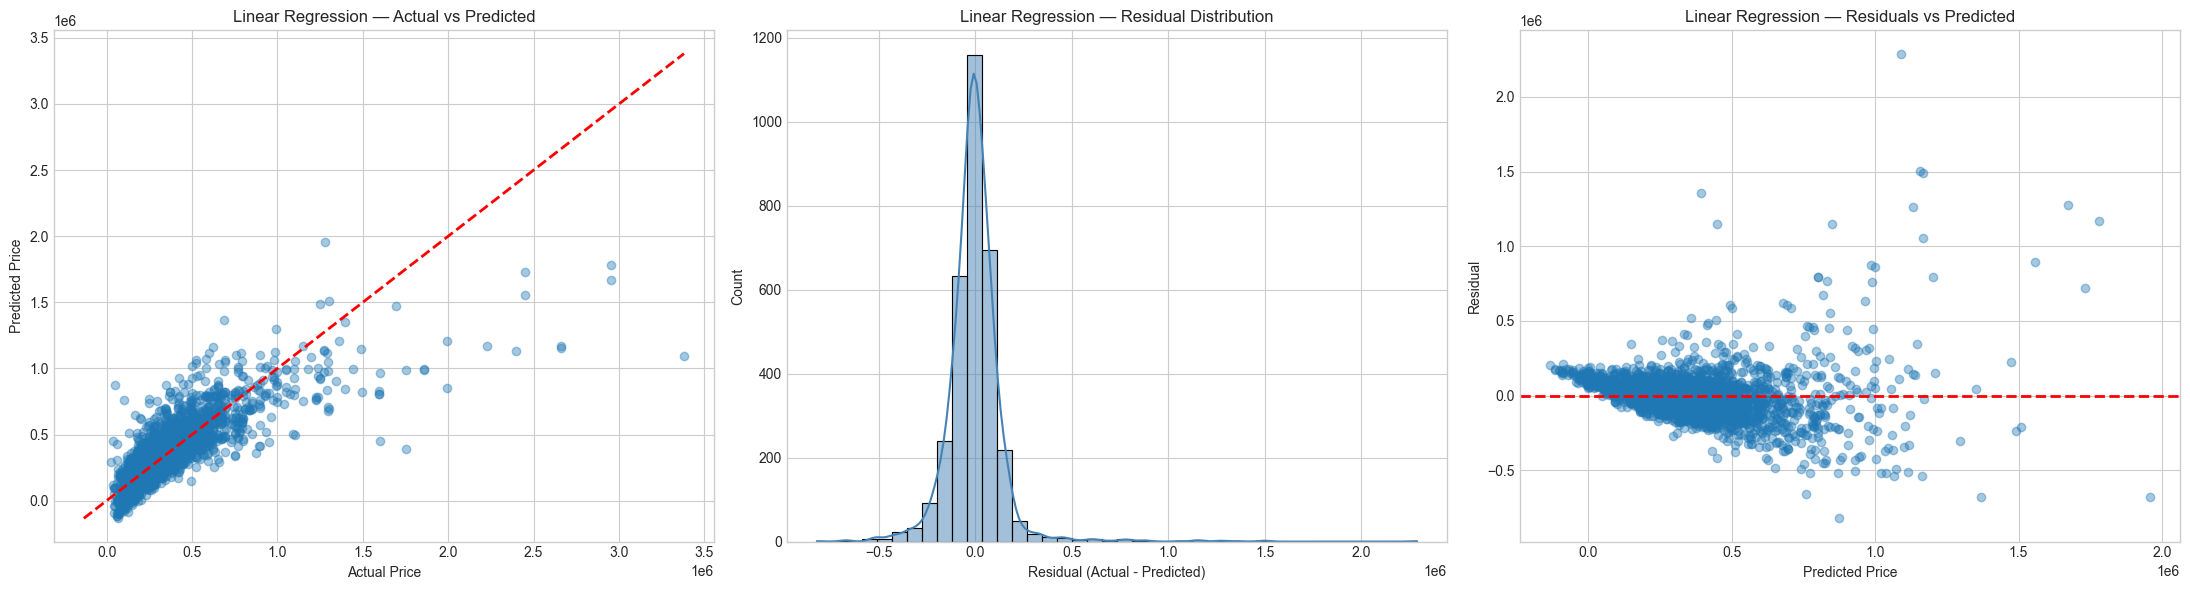

In [7]:
# ============================================================
# LINEAR REGRESSION — TRAIN / VAL / TEST
# ============================================================

# Build X, y from Stage 3 outputs
X_train_lr, y_train_lr = prepare_X_y(df_train, model_type="linear")
X_val_lr,   y_val_lr   = prepare_X_y(df_val,   model_type="linear")
X_test_lr,  y_test_lr  = prepare_X_y(df_test,  model_type="linear")

print("Shapes (LR):")
print("X_train:", X_train_lr.shape, " y_train:", y_train_lr.shape)
print("X_val  :", X_val_lr.shape,   " y_val  :", y_val_lr.shape)
print("X_test :", X_test_lr.shape,  " y_test :", y_test_lr.shape)

print("\nNaNs in X_train (before imputer):", int(X_train_lr.isna().sum().sum()))

# Pipeline: Impute (median) + Linear Regression
lr_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ]
)

# Fit on TRAIN only
lr_pipeline.fit(X_train_lr, y_train_lr)

# Evaluate on TRAIN, VAL, TEST
y_pred_train_lr = lr_pipeline.predict(X_train_lr)
y_pred_val_lr   = lr_pipeline.predict(X_val_lr)
y_pred_test_lr  = lr_pipeline.predict(X_test_lr)

print("\n--- Linear Regression (Train) ---")
evaluate_regression("LR — Train", y_train_lr, y_pred_train_lr)

print("\n--- Linear Regression (Validation) ---")
evaluate_regression("LR — Validation", y_val_lr, y_pred_val_lr)

print("\n--- Linear Regression (Test) ---")
evaluate_regression("LR — Test", y_test_lr, y_pred_test_lr)

# Diagnostics plots on TEST
plot_regression_diagnostics(y_test_lr, y_pred_test_lr, title_prefix="Linear Regression")


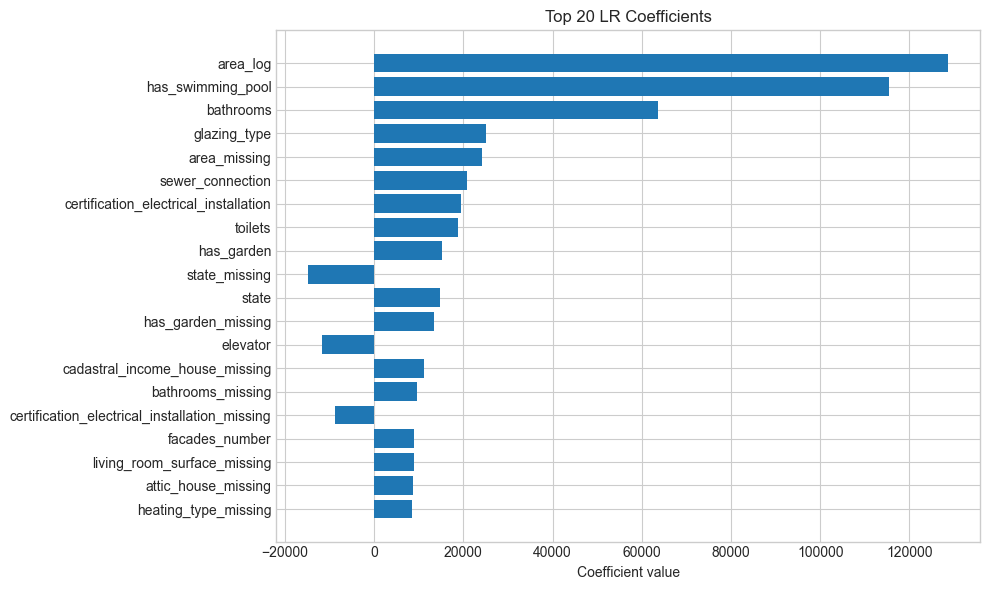

In [7]:
# ============================================================
# LR FEATURE IMPORTANCE (using coefficients)
# ============================================================

lr_model = lr_pipeline.named_steps["model"]
plot_lr_feature_importance(
    lr_model,
    X_train_lr.columns,
    top_n=20,
    title="Top 20 LR Coefficients"
)


Shapes (RF):
X_train: (15030, 76)  y_train: (15030,)
X_val  : (3221, 76)  y_val  : (3221,)
X_test : (3221, 76)  y_test : (3221,)

NaNs in X_train (before imputer): 0

--- Random Forest (Train) ---
===== RF — Train =====
MAE: 18,111.39
R² : 0.9773

--- Random Forest (Validation) ---
===== RF — Validation =====
MAE: 51,051.44
R² : 0.8518

--- Random Forest (Test) ---
===== RF — Test =====
MAE: 53,086.94
R² : 0.7510


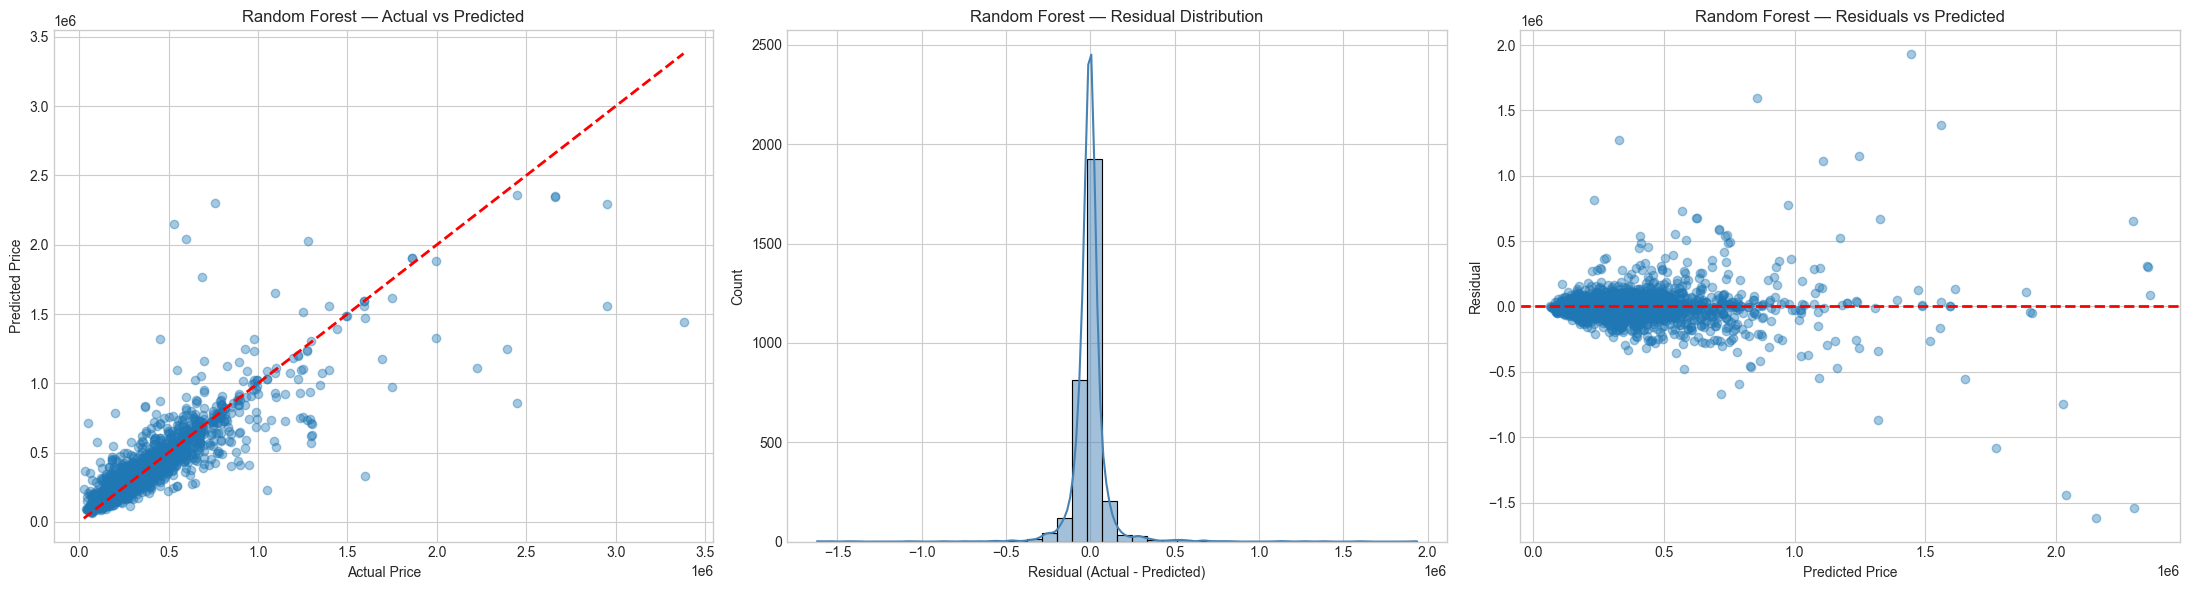

In [8]:
# ============================================================
# RANDOM FOREST — TRAIN / VAL / TEST
# ============================================================

X_train_rf, y_train_rf = prepare_X_y(df_train, model_type="rf")
X_val_rf,   y_val_rf   = prepare_X_y(df_val,   model_type="rf")
X_test_rf,  y_test_rf  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (RF):")
print("X_train:", X_train_rf.shape, " y_train:", y_train_rf.shape)
print("X_val  :", X_val_rf.shape,   " y_val  :", y_val_rf.shape)
print("X_test :", X_test_rf.shape,  " y_test :", y_test_rf.shape)

print("\nNaNs in X_train (before imputer):", int(X_train_rf.isna().sum().sum()))

# Pipeline: Impute (median) + RandomForest
rf_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Fit on TRAIN
rf_pipeline.fit(X_train_rf, y_train_rf)

# Predict
y_pred_train_rf = rf_pipeline.predict(X_train_rf)
y_pred_val_rf   = rf_pipeline.predict(X_val_rf)
y_pred_test_rf  = rf_pipeline.predict(X_test_rf)

print("\n--- Random Forest (Train) ---")
evaluate_regression("RF — Train", y_train_rf, y_pred_train_rf)

print("\n--- Random Forest (Validation) ---")
evaluate_regression("RF — Validation", y_val_rf, y_pred_val_rf)

print("\n--- Random Forest (Test) ---")
evaluate_regression("RF — Test", y_test_rf, y_pred_test_rf)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_rf, y_pred_test_rf, title_prefix="Random Forest")


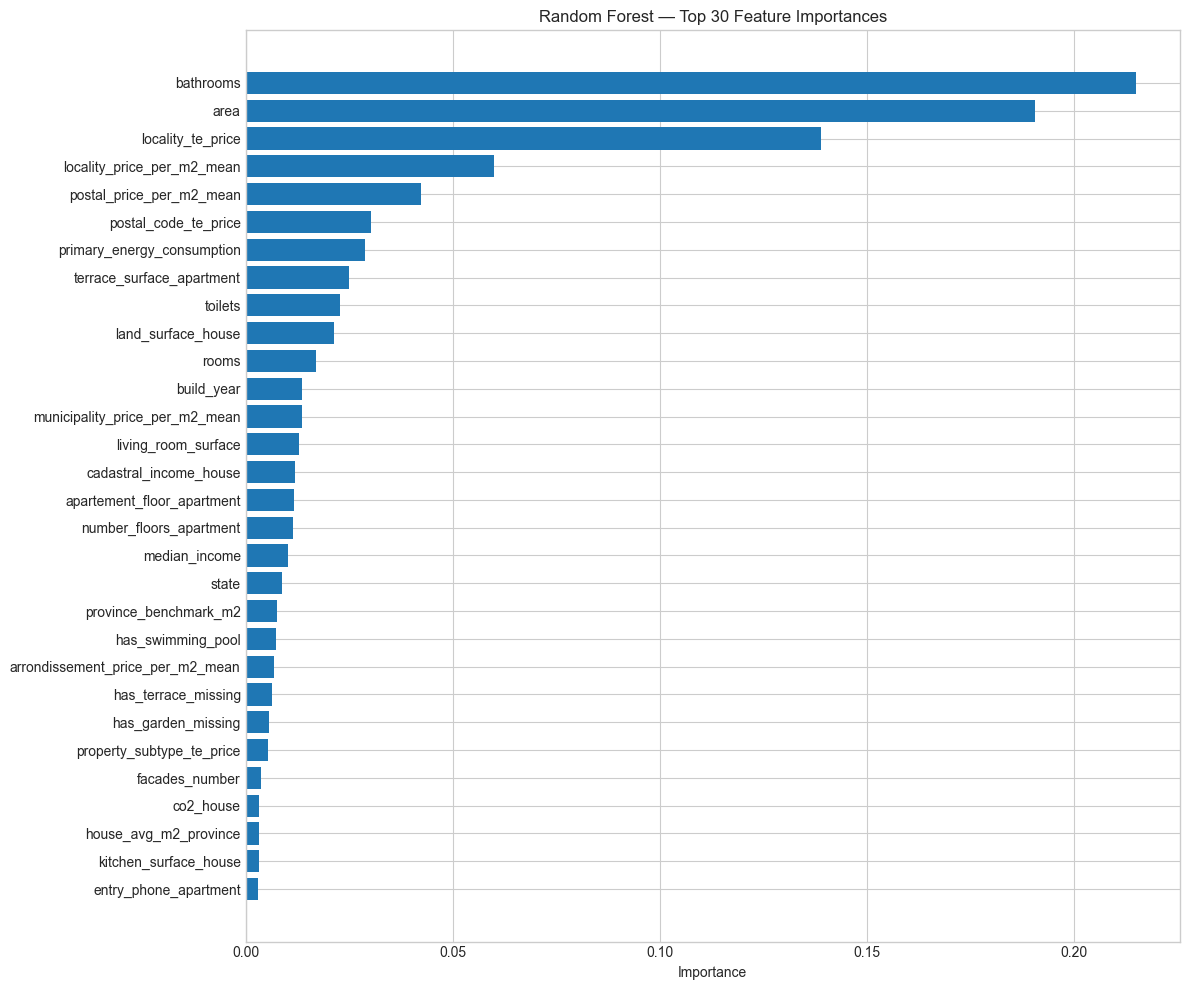

In [9]:
# ============================================================
# RF FEATURE IMPORTANCE
# ============================================================

rf_model = rf_pipeline.named_steps["model"]

plot_tree_importances(
    rf_model,
    X_train_rf.columns,
    top_n=30,
    title="Random Forest — Top 30 Feature Importances"
)


Shapes (Decision Tree):
X_train: (14630, 68)  y_train: (14630,)
X_val  : (3135, 68)  y_val  : (3135,)
X_test : (3135, 68)  y_test : (3135,)

--- Decision Tree (Train) ---
===== Decision Tree — Train =====
MAE: 307.82
R² : 0.9998

--- Decision Tree (Validation) ---
===== Decision Tree — Validation =====
MAE: 74,695.14
R² : 0.4310

--- Decision Tree (Test) ---
===== Decision Tree — Test =====
MAE: 75,906.13
R² : 0.5426


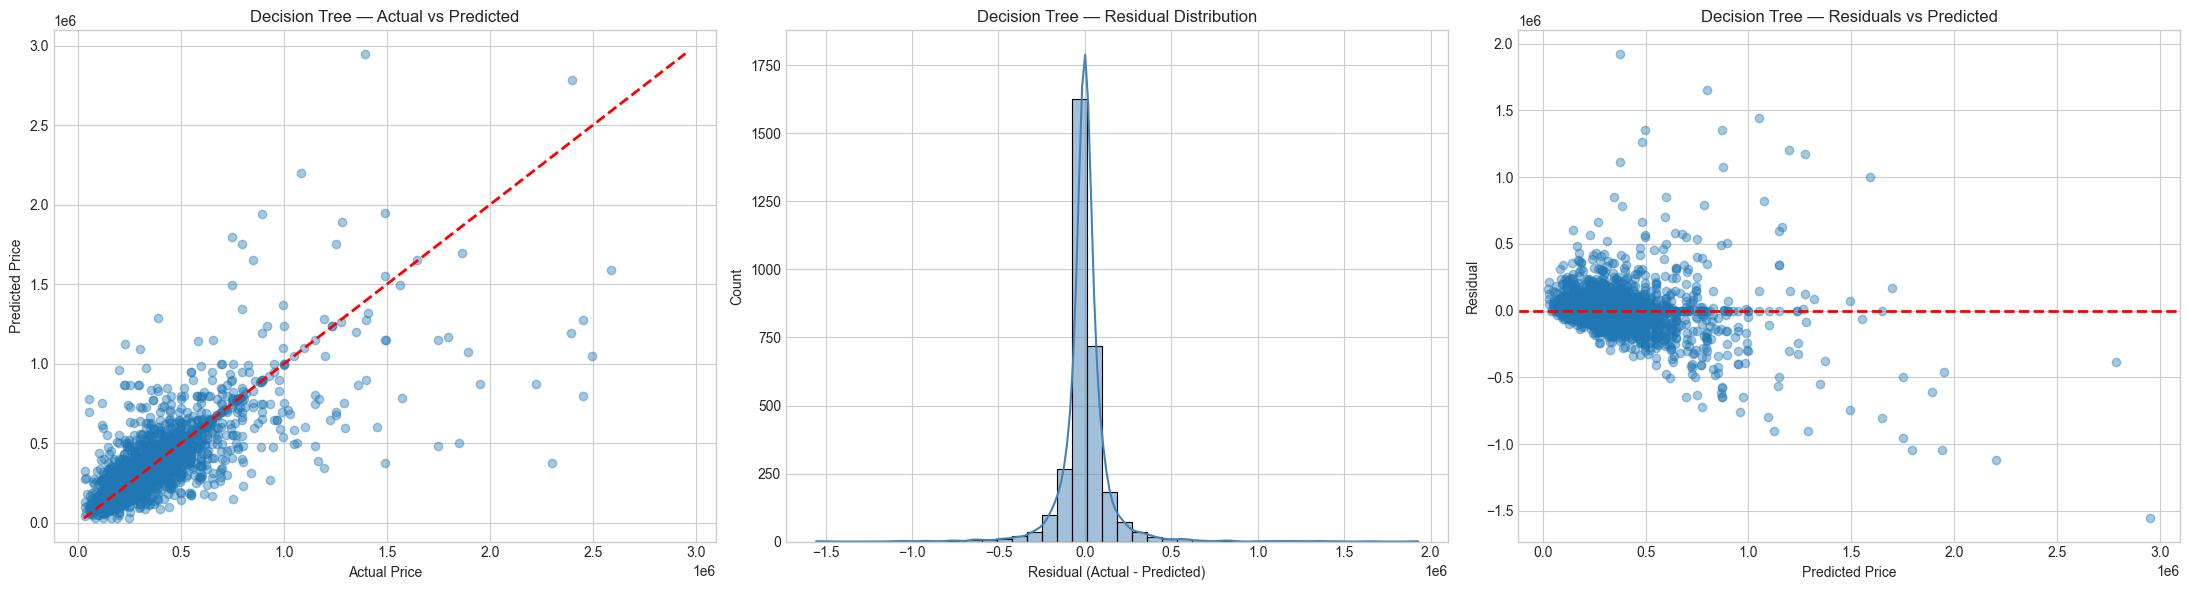

In [10]:
# ============================================================
# DECISION TREE REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y
X_train_dt, y_train_dt = prepare_X_y(df_train, model_type="rf")
X_val_dt,   y_val_dt   = prepare_X_y(df_val,   model_type="rf")
X_test_dt,  y_test_dt  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (Decision Tree):")
print("X_train:", X_train_dt.shape, " y_train:", y_train_dt.shape)
print("X_val  :", X_val_dt.shape,   " y_val  :", y_val_dt.shape)
print("X_test :", X_test_dt.shape,  " y_test :", y_test_dt.shape)

# Pipeline: Impute + Decision Tree
dt_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", DecisionTreeRegressor(
            max_depth=None,
            min_samples_split=2,
            random_state=42
        ))
    ]
)

# Fit
dt_pipeline.fit(X_train_dt, y_train_dt)

# Predict
y_pred_train_dt = dt_pipeline.predict(X_train_dt)
y_pred_val_dt   = dt_pipeline.predict(X_val_dt)
y_pred_test_dt  = dt_pipeline.predict(X_test_dt)

# Evaluate
print("\n--- Decision Tree (Train) ---")
evaluate_regression("Decision Tree — Train", y_train_dt, y_pred_train_dt)

print("\n--- Decision Tree (Validation) ---")
evaluate_regression("Decision Tree — Validation", y_val_dt, y_pred_val_dt)

print("\n--- Decision Tree (Test) ---")
evaluate_regression("Decision Tree — Test", y_test_dt, y_pred_test_dt)

# Diagnostics plots on TEST
plot_regression_diagnostics(y_test_dt, y_pred_test_dt, title_prefix="Decision Tree")


Shapes (SVR):
X_train: (14630, 65)  y_train: (14630,)
X_val  : (3135, 65)  y_val  : (3135,)
X_test : (3135, 65)  y_test : (3135,)

--- SVR (Train) ---
===== SVR — Train =====
MAE: 137,669.42
R² : -0.0380

--- SVR (Validation) ---
===== SVR — Validation =====
MAE: 134,696.21
R² : -0.0369

--- SVR (Test) ---
===== SVR — Test =====
MAE: 137,666.77
R² : -0.0415


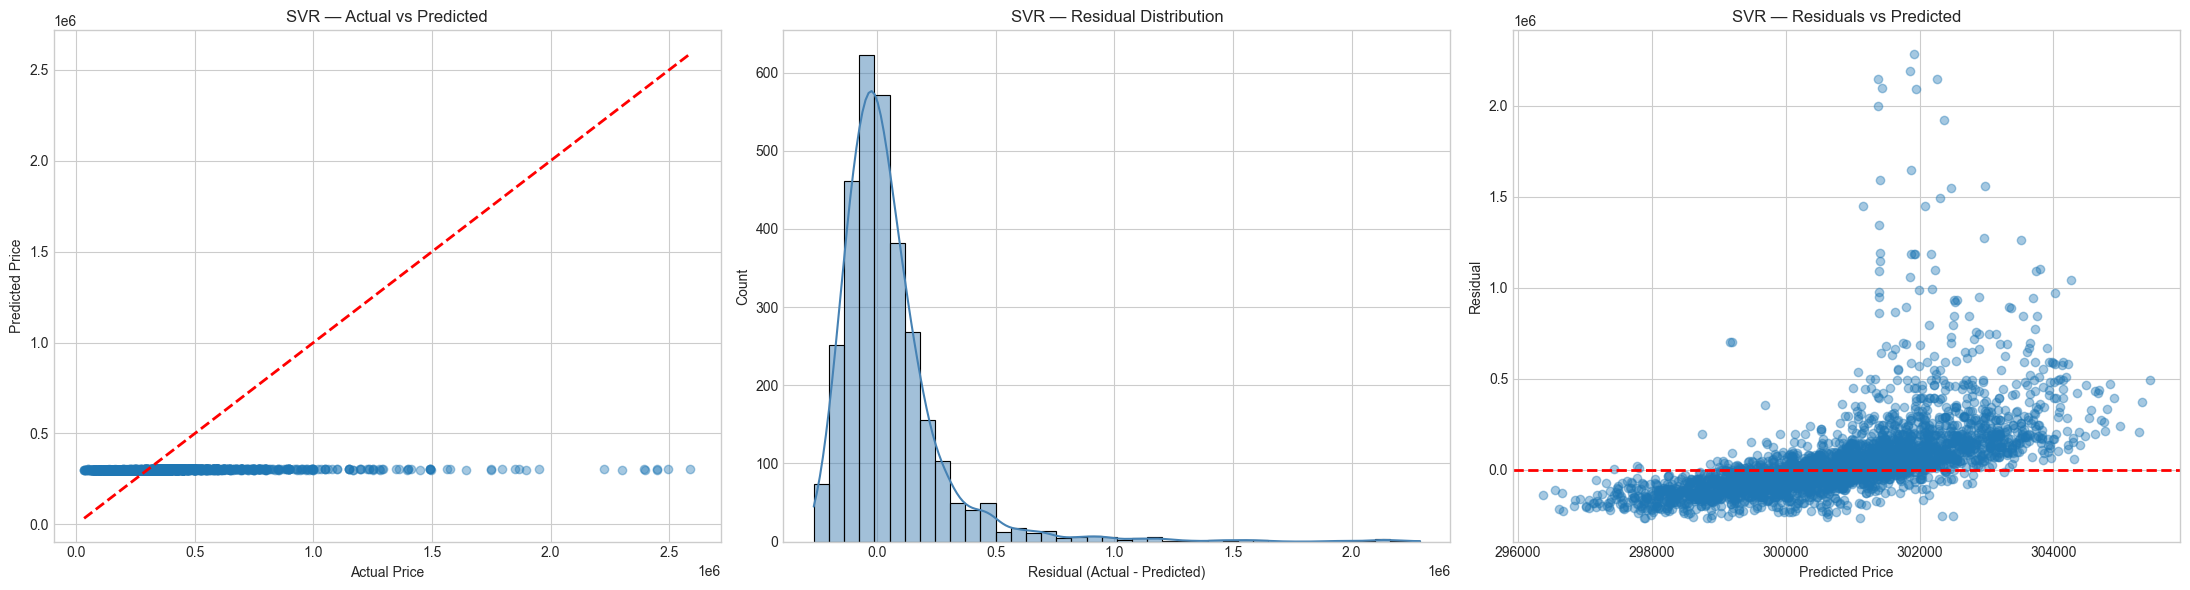

In [11]:
# ============================================================
# SUPPORT VECTOR REGRESSION (SVR) — TRAIN / VAL / TEST
# ============================================================

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y
X_train_svr, y_train_svr = prepare_X_y(df_train, model_type="linear")  # numeric only
X_val_svr,   y_val_svr   = prepare_X_y(df_val,   model_type="linear")
X_test_svr,  y_test_svr  = prepare_X_y(df_test,  model_type="linear")

print("Shapes (SVR):")
print("X_train:", X_train_svr.shape, " y_train:", y_train_svr.shape)
print("X_val  :", X_val_svr.shape,   " y_val  :", y_val_svr.shape)
print("X_test :", X_test_svr.shape,  " y_test :", y_test_svr.shape)

# Pipeline: Imputer + Scaler + SVR
svr_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", SVR(
            kernel="rbf",
            C=10,
            epsilon=0.1
        ))
    ]
)

# Fit
svr_pipeline.fit(X_train_svr, y_train_svr)

# Predict
y_pred_train_svr = svr_pipeline.predict(X_train_svr)
y_pred_val_svr   = svr_pipeline.predict(X_val_svr)
y_pred_test_svr  = svr_pipeline.predict(X_test_svr)

# Evaluate
print("\n--- SVR (Train) ---")
evaluate_regression("SVR — Train", y_train_svr, y_pred_train_svr)

print("\n--- SVR (Validation) ---")
evaluate_regression("SVR — Validation", y_val_svr, y_pred_val_svr)

print("\n--- SVR (Test) ---")
evaluate_regression("SVR — Test", y_test_svr, y_pred_test_svr)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_svr, y_pred_test_svr, title_prefix="SVR")


Shapes (XGBoost):
X_train: (15030, 76)  y_train: (15030,)
X_val  : (3221, 76)  y_val  : (3221,)
X_test : (3221, 76)  y_test : (3221,)

--- XGBoost (Train) ---
===== XGBoost — Train =====
MAE: 18,270.24
R² : 0.9901

--- XGBoost (Validation) ---
===== XGBoost — Validation =====
MAE: 45,908.75
R² : 0.8883

--- XGBoost (Test) ---
===== XGBoost — Test =====
MAE: 49,240.93
R² : 0.7784


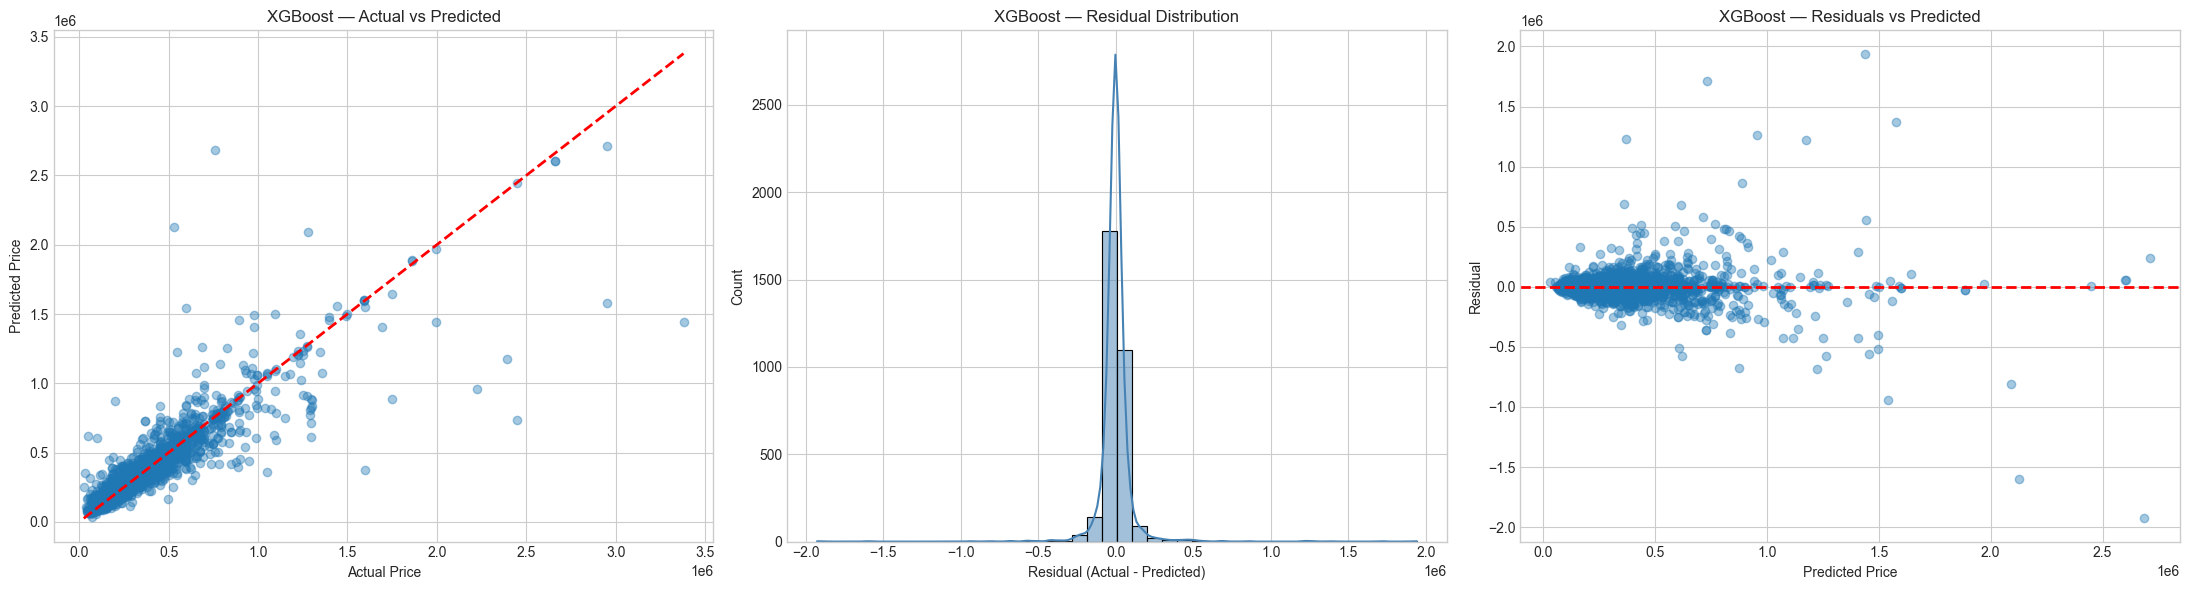

In [10]:
# ============================================================
# XGBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → use model_type="rf")
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (XGBoost):")
print("X_train:", X_train_xgb.shape, " y_train:", y_train_xgb.shape)
print("X_val  :", X_val_xgb.shape,   " y_val  :", y_val_xgb.shape)
print("X_test :", X_test_xgb.shape,  " y_test :", y_test_xgb.shape)

# Pipeline: Imputer + XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # optional: XGB handles NaNs
        ("model", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ]
)

# Fit
xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_train_xgb = xgb_pipeline.predict(X_train_xgb)
y_pred_val_xgb   = xgb_pipeline.predict(X_val_xgb)
y_pred_test_xgb  = xgb_pipeline.predict(X_test_xgb)

# Evaluate
print("\n--- XGBoost (Train) ---")
evaluate_regression("XGBoost — Train", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation) ---")
evaluate_regression("XGBoost — Validation", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test) ---")
evaluate_regression("XGBoost — Test", y_test_xgb, y_pred_test_xgb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGBoost")


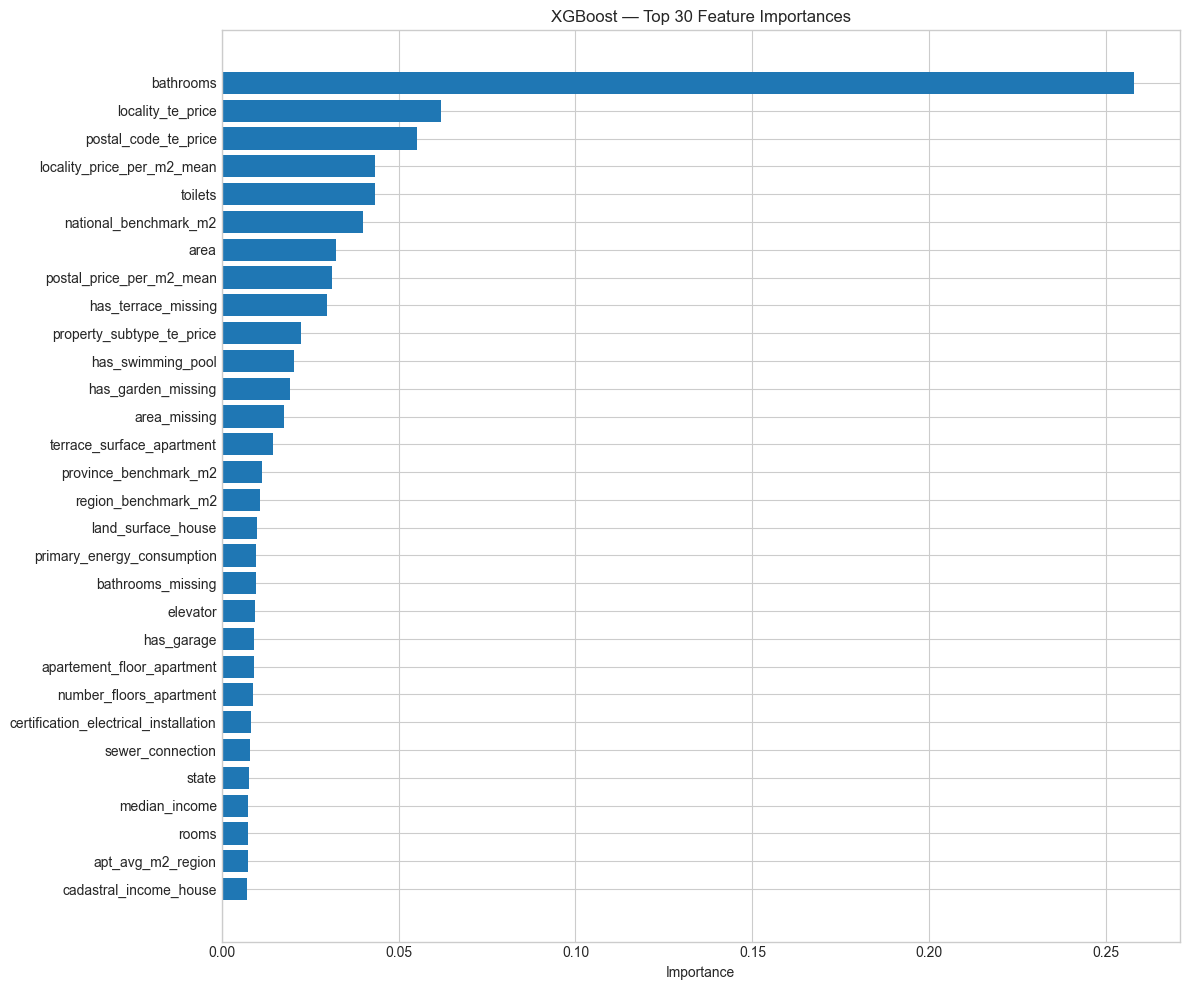

In [11]:
# ============================================================
# XGBOOST FEATURE IMPORTANCE
# ============================================================

xgb_model = xgb_pipeline.named_steps["model"]
importances = xgb_model.feature_importances_

plot_tree_importances(
    xgb_model,
    X_train_xgb.columns,
    top_n=30,
    title="XGBoost — Top 30 Feature Importances"
)


Shapes (XGBoost):
X_train: (15030, 76)  y_train: (15030,)
X_val  : (3221, 76)  y_val  : (3221,)
X_test : (3221, 76)  y_test : (3221,)

Running XGBoost tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Hyperparameters:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 500, 'model__subsample': 0.8}
Best CV MAE: 46953.93321391072

--- XGBoost (Train, tuned) ---
===== XGB — Train (tuned) =====
MAE: 5,381.91
R² : 0.9990

--- XGBoost (Validation, tuned) ---
===== XGB — Validation (tuned) =====
MAE: 43,476.89
R² : 0.8882

--- XGBoost (Test, tuned) ---
===== XGB — Test (tuned) =====
MAE: 46,617.17
R² : 0.7712


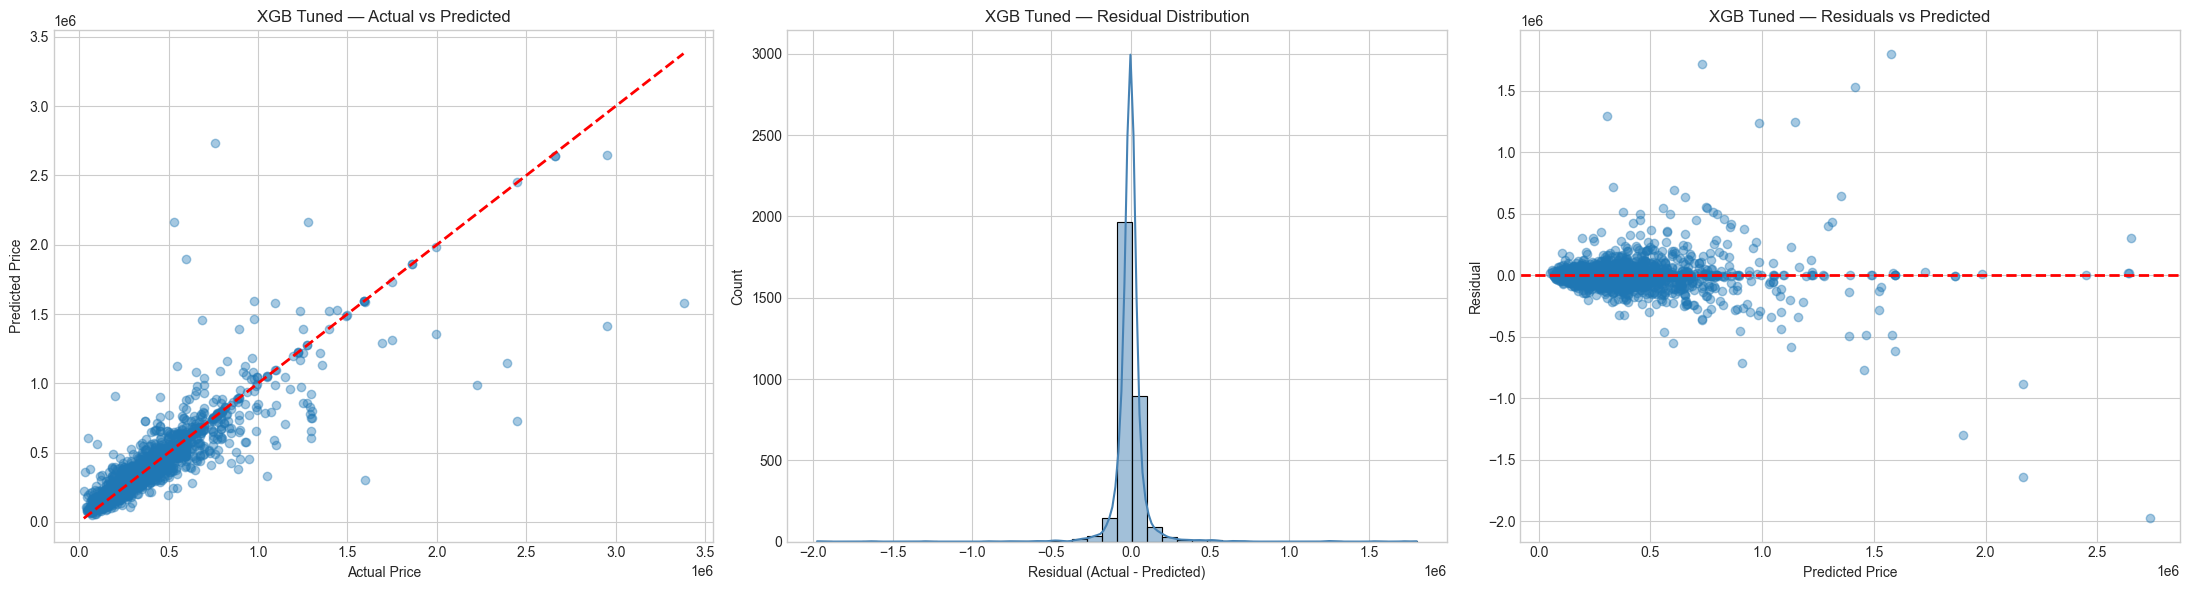

In [16]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

# ============================================================
# 0. Prepare data (from Stage2 → Stage3 split)
# ============================================================
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (XGBoost):")
print("X_train:", X_train_xgb.shape, " y_train:", y_train_xgb.shape)
print("X_val  :", X_val_xgb.shape,   " y_val  :", y_val_xgb.shape)
print("X_test :", X_test_xgb.shape,  " y_test :", y_test_xgb.shape)

# ============================================================
# 1. Build XGBoost tuning pipeline
# ============================================================
xgb_tune_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # XGB can handle NaN but keep consistent
        ("model", XGBRegressor(
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"  # fastest option
        ))
    ]
)

# ============================================================
# 2. VERY light tuning grid (fast, meaningful)
# ============================================================
param_grid = {
    "model__n_estimators": [300, 400, 500],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [6, 10],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.8]
}

# ============================================================
# 3. 3-Fold CV setup
# ============================================================
cv = KFold(n_splits=3, shuffle=True, random_state=42)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator=xgb_tune_pipeline,
    param_grid=param_grid,
    scoring=mae_scorer,   # MAE for real estate stability
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# ============================================================
# 4. Run grid search — TRAIN ONLY (no leakage)
# ============================================================
print("\nRunning XGBoost tuning...")
grid.fit(X_train_xgb, y_train_xgb)

print("\nBest Hyperparameters:")
print(grid.best_params_)
print("Best CV MAE:", abs(grid.best_score_))

# ============================================================
# 5. Refit best model on full TRAIN
# ============================================================
best_xgb = grid.best_estimator_

# ============================================================
# 6. Predict on Train / Val / Test
# ============================================================
y_pred_train_xgb = best_xgb.predict(X_train_xgb)
y_pred_val_xgb   = best_xgb.predict(X_val_xgb)
y_pred_test_xgb  = best_xgb.predict(X_test_xgb)

# ============================================================
# 7. Evaluate
# ============================================================
print("\n--- XGBoost (Train, tuned) ---")
evaluate_regression("XGB — Train (tuned)", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation, tuned) ---")
evaluate_regression("XGB — Validation (tuned)", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test, tuned) ---")
evaluate_regression("XGB — Test (tuned)", y_test_xgb, y_pred_test_xgb)

# Diagnostics
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGB Tuned")


In [17]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# ============================================================
# 0. Rebuild your BEST XGBoost model
# ============================================================
best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. 5-Fold CV setup
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), 
                        greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# ============================================================
# 2. Run the 5-Fold CV
# ============================================================
cv_results = cross_validate(
    estimator=best_xgb_pipeline,
    X=X_train_xgb,
    y=y_train_xgb,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

# ============================================================
# 3. Print results
# ============================================================
print("\n========== 5-FOLD CROSS VALIDATION RESULTS (BEST XGBOOST) ==========\n")

for metric in ["MAE", "RMSE", "R2"]:
    mean_score = abs(cv_results[f"test_{metric}"]).mean() if metric != "R2" else cv_results[f"test_{metric}"].mean()
    std_score = abs(cv_results[f"test_{metric}"]).std() if metric != "R2" else cv_results[f"test_{metric}"].std()

    print(f"{metric}:  {mean_score:.4f} ± {std_score:.4f}")

print("\n====================================================================")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



========== 5-FOLD CROSS VALIDATION RESULTS (BEST XGBOOST) ==========

MAE:  45249.5564 ± 1405.0167
RMSE:  103317.7083 ± 9616.1631
R2:  0.8474 ± 0.0230



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Top 30 Features (by Gain):


,feature,gain
13,f13,836605444096.00
74,f75,182901374976.00
68,f69,147468140544.00
32,f33,141354516480.00
41,f42,140912721920.00
73,f74,133645303808.00
67,f68,77738590208.00
7,f7,75681587200.00
46,f47,71517667328.00
1,f1,71067123712.00



Top 30 Features with Real Names:


,real_feature,gain
13,bathrooms,836605444096.00
74,locality_te_price,182901374976.00
68,locality_price_per_m2_mean,147468140544.00
32,toilets,141354516480.00
41,national_benchmark_m2,140912721920.00
73,postal_code_te_price,133645303808.00
67,postal_price_per_m2_mean,77738590208.00
7,has_swimming_pool,75681587200.00
46,has_terrace_missing,71517667328.00
1,area,71067123712.00


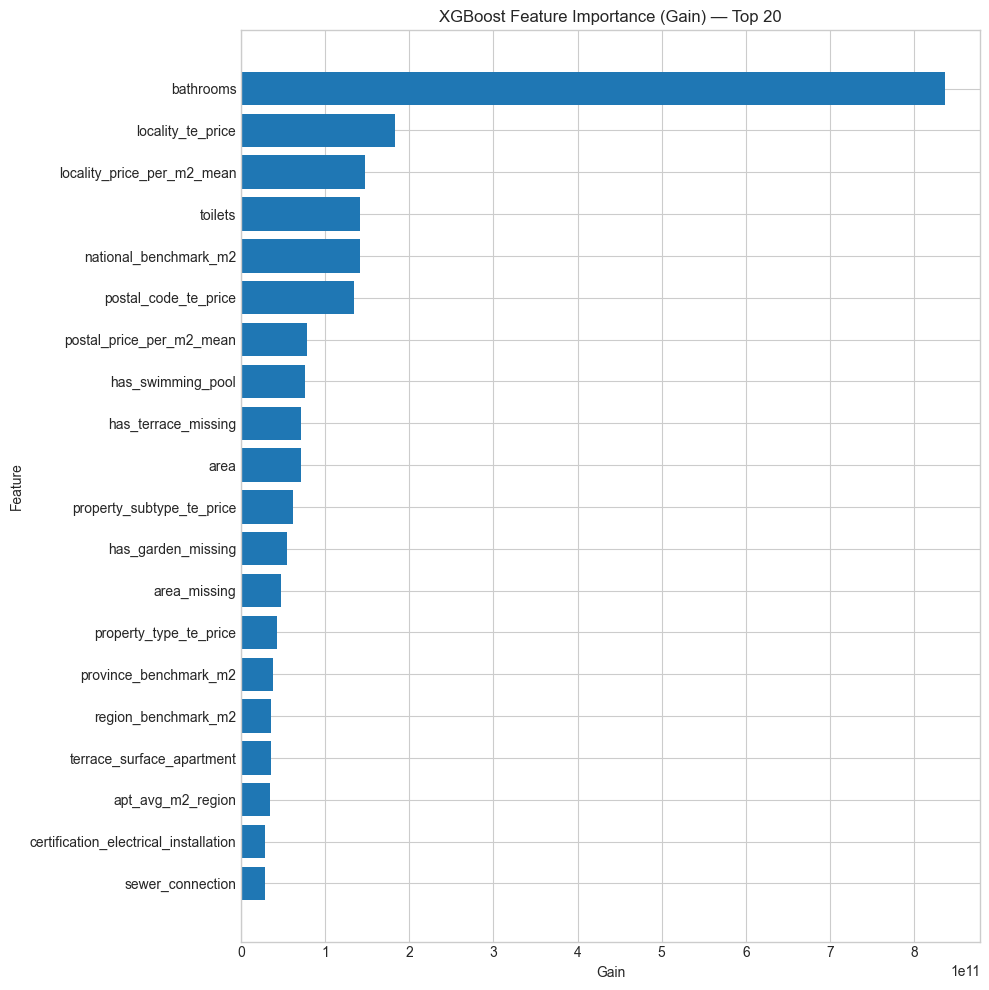

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. Extract trained XGBoost model from pipeline
# ============================================================
xgb_model = best_xgb_pipeline.named_steps["model"]

# ============================================================
# 2. Get feature importances (Gain-based)
# ============================================================
importances = xgb_model.get_booster().get_score(importance_type="gain")

# Convert dict → DataFrame
importance_df = (
    pd.DataFrame([
        {"feature": k, "gain": v} 
        for k, v in importances.items()
    ])
    .sort_values("gain", ascending=False)
)

print("Top 30 Features (by Gain):")
display(importance_df.head(30))

# ============================================================
# 3. Match back to your actual feature names
# ============================================================
# NOTE: XGBoost uses f0, f1, f2... so map them:
feature_map = {
    f"f{i}": col for i, col in enumerate(X_train_xgb.columns)
}

importance_df["real_feature"] = importance_df["feature"].map(feature_map)

print("\nTop 30 Features with Real Names:")
display(importance_df[["real_feature", "gain"]].head(30))

# ============================================================
# 4. PLOT (Top 20)
# ============================================================
topk = 20
plot_df = importance_df.head(topk).copy()
plot_df["real_feature"] = plot_df["real_feature"].astype(str)

plt.figure(figsize=(10, 10))
plt.barh(plot_df["real_feature"][::-1], plot_df["gain"][::-1])
plt.title("XGBoost Feature Importance (Gain) — Top 20")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing SHAP values… (this may take a few seconds)


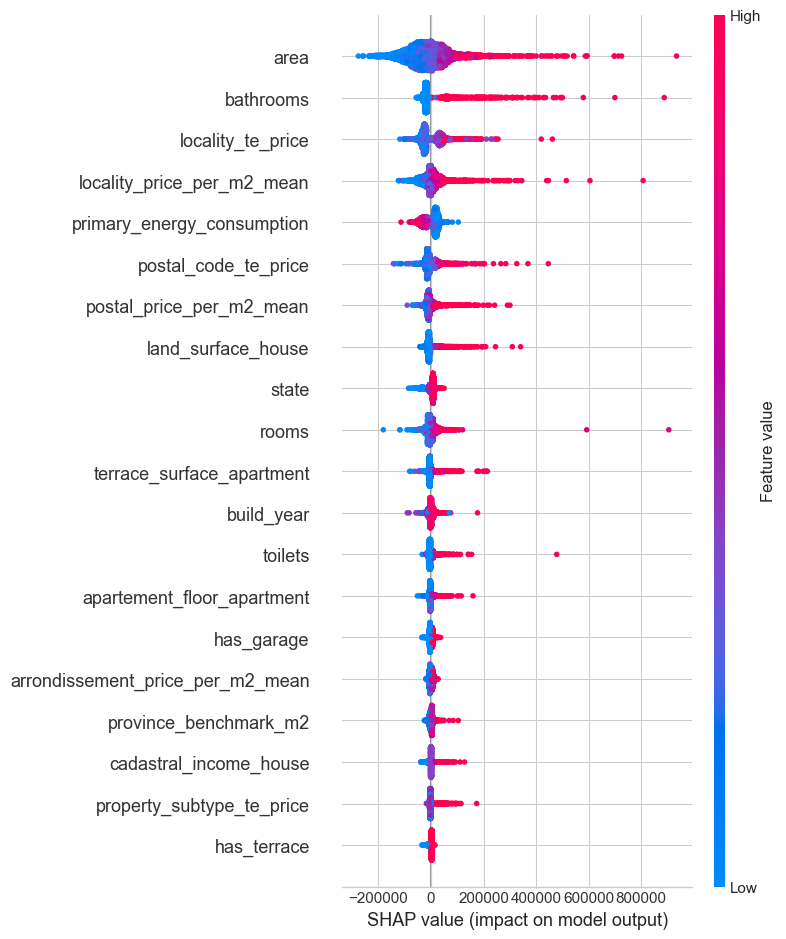

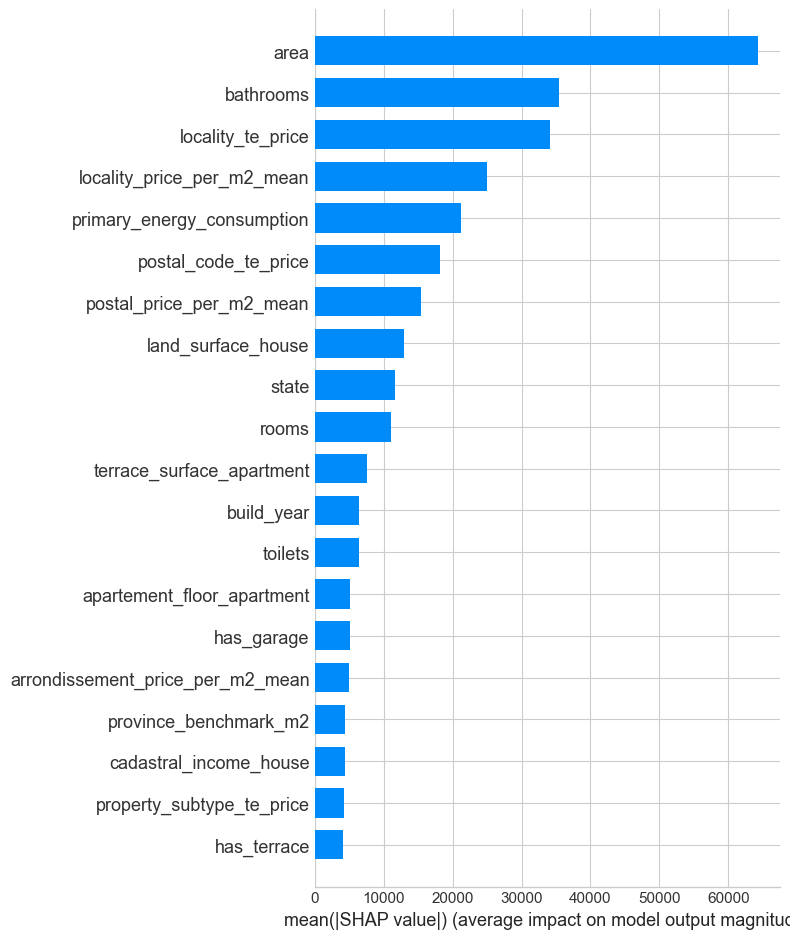


Top 20 Features by Mean |SHAP|:


,feature,mean_abs_shap
1,area,64264.16
13,bathrooms,35465.64
75,locality_te_price,34190.00
69,locality_price_per_m2_mean,24941.71
19,primary_energy_consumption,21164.84
74,postal_code_te_price,18165.69
68,postal_price_per_m2_mean,15448.78
16,land_surface_house,13022.36
2,state,11648.03
0,rooms,11108.33


In [21]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Fit your tuned model (if not already fitted)
# ============================================================
best_xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Extract trained XGB model
xgb_model = best_xgb_pipeline.named_steps["model"]

# ============================================================
# 2. Prepare a sample for SHAP (faster, avoids memory overload)
# ============================================================
sample_size = min(5000, X_train_xgb.shape[0])  # cap at 5000 rows
X_sample = X_train_xgb.sample(sample_size, random_state=42)

# ============================================================
# 3. Create SHAP Explainer
# ============================================================
explainer = shap.TreeExplainer(xgb_model)

print("Computing SHAP values… (this may take a few seconds)")
shap_values = explainer.shap_values(X_sample)

# ============================================================
# 4. SHAP Summary Plot (global feature importance)
# ============================================================
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=True)

# ============================================================
# 5. SHAP Feature Importance Bar Plot
# ============================================================
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# ============================================================
# 6. (Optional) Get mean absolute SHAP per feature in a DF
# ============================================================
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_train_xgb.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("\nTop 20 Features by Mean |SHAP|:")
display(shap_df.head(20))


In [18]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# ============================================================
# 0. Rebuild your BEST XGBoost model
# ============================================================
best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. 5-Fold CV setup
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
                        greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# ============================================================
# 2. Run the 5-Fold CV (TRAIN ONLY)
# ============================================================
cv_results = cross_validate(
    estimator=best_xgb_pipeline,
    X=X_train_xgb,
    y=y_train_xgb,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

print("\n========== 5-FOLD CROSS VALIDATION RESULTS ==========\n")

for metric in ["MAE", "RMSE", "R2"]:
    scores = cv_results[f"test_{metric}"]
    # MAE & RMSE negative because of scorer → take abs for readability
    if metric in ["MAE", "RMSE"]:
        mean_score = abs(scores.mean())
        std_score = abs(scores.std())
    else:
        mean_score = scores.mean()
        std_score = scores.std()
    print(f"{metric}:  {mean_score:.4f} ± {std_score:.4f}")

print("\n=====================================================\n")

# ============================================================
# 3. Refit the model on full TRAIN
# ============================================================
best_xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# ============================================================
# 4. Evaluate on TRAIN and VALIDATION
# ============================================================
y_pred_train = best_xgb_pipeline.predict(X_train_xgb)
y_pred_val   = best_xgb_pipeline.predict(X_val_xgb)

print("\n========== TRAIN PERFORMANCE (BEST XGBoost) ==========\n")
evaluate_regression("XGB — Train", y_train_xgb, y_pred_train)

print("\n========== VALIDATION PERFORMANCE (BEST XGBoost) ==========\n")
evaluate_regression("XGB — Validation", y_val_xgb, y_pred_val)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished



========== 5-FOLD CROSS VALIDATION RESULTS ==========

MAE:  45249.5564 ± 1405.0167
RMSE:  103317.7083 ± 9616.1631
R2:  0.8474 ± 0.0230



========== TRAIN PERFORMANCE (BEST XGBoost) ==========

===== XGB — Train =====
MAE: 5,381.91
R² : 0.9990

========== VALIDATION PERFORMANCE (BEST XGBoost) ==========

===== XGB — Validation =====
MAE: 43,476.89
R² : 0.8882


(43476.885534505, 0.8882300141589619)


=== XGBoost Feature Importance (Gain / Weight / Cover) ===
                feature             gain  weight   cover
13            bathrooms 1334452289536.00  843.00 1264.22
61  locality_price_mean  719262777344.00 2055.00 1169.40
38  has_terrace_missing  282408648704.00  179.00  663.24
32              toilets  240737222656.00  819.00  741.79
7     has_swimming_pool  180306788352.00  294.00  872.54
..                  ...              ...     ...     ...
43       cellar_missing   14560934912.00  151.00  230.67
10               cellar   13780228096.00  310.00  124.70
25          attic_house   12898046976.00  168.00  859.01
23               leased   12682991616.00   71.00 1705.80
26         glazing_type   12610095104.00  177.00 2144.05

[67 rows x 4 columns]


<Figure size 1000x600 with 0 Axes>

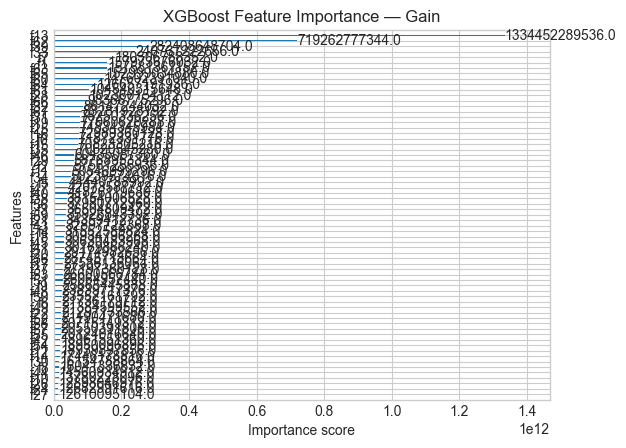

<Figure size 1000x600 with 0 Axes>

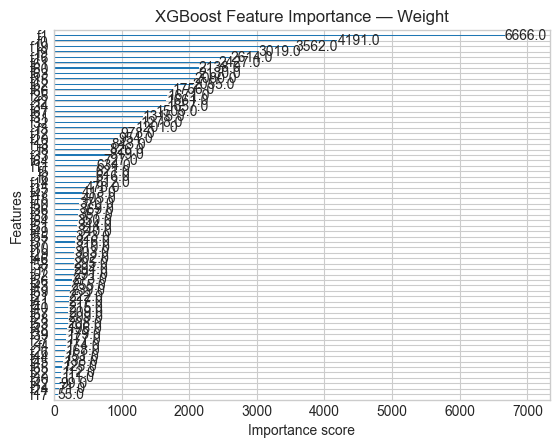

<Figure size 1000x600 with 0 Axes>

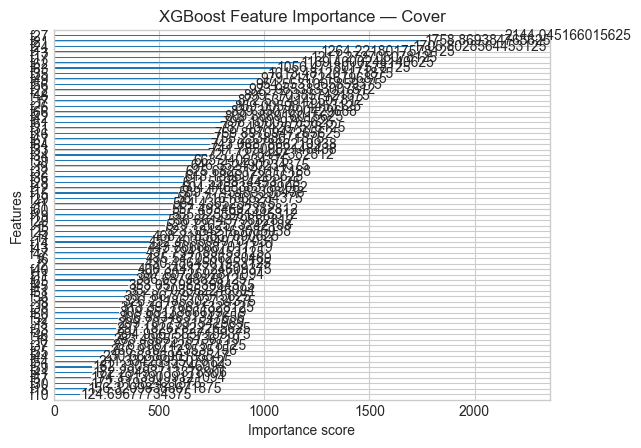

In [19]:
# ============================================================
# 7) FEATURE IMPORTANCE — Gain / Weight / Cover
# ============================================================

from xgboost import plot_importance   # <-- REQUIRED IMPORT

# Extract booster from pipeline
booster = xgb_pipeline.named_steps["model"].get_booster()

# Raw importance dicts
gain_dict   = booster.get_score(importance_type="gain")
weight_dict = booster.get_score(importance_type="weight")
cover_dict  = booster.get_score(importance_type="cover")

# Map f0 → actual column names
columns = X_train_xgb.columns

importance_df = pd.DataFrame({
    "feature": [columns[int(f[1:])] for f in gain_dict.keys()],
    "gain":    [gain_dict[f] for f in gain_dict.keys()],
    "weight":  [weight_dict.get(f, 0) for f in gain_dict.keys()],
    "cover":   [cover_dict.get(f, 0) for f in gain_dict.keys()]
}).sort_values(by="gain", ascending=False)

print("\n=== XGBoost Feature Importance (Gain / Weight / Cover) ===")
print(importance_df)

# ---------------------------
# Plot — Gain
# ---------------------------
plt.figure(figsize=(10, 6))
plot_importance(xgb_pipeline.named_steps["model"], importance_type="gain")
plt.title("XGBoost Feature Importance — Gain")
plt.show()

# ---------------------------
# Plot — Weight
# ---------------------------
plt.figure(figsize=(10, 6))
plot_importance(xgb_pipeline.named_steps["model"], importance_type="weight")
plt.title("XGBoost Feature Importance — Weight")
plt.show()

# ---------------------------
# Plot — Cover
# ---------------------------
plt.figure(figsize=(10, 6))
plot_importance(xgb_pipeline.named_steps["model"], importance_type="cover")
plt.title("XGBoost Feature Importance — Cover")
plt.show()


Shapes (LightGBM):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 15152, number of used features: 67
[LightGBM] [Info] Start training from score 354734.727891


c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Chaib\Documents\GitHub\immo-eliza-Amine\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- LightGBM (Train) ---
===== LightGBM — Train =====
MAE: 26,530.10
R² : 0.9640

--- LightGBM (Validation) ---
===== LightGBM — Validation =====
MAE: 58,351.63
R² : 0.7345

--- LightGBM (Test) ---
===== LightGBM — Test =====
MAE: 55,936.45
R² : 0.6704


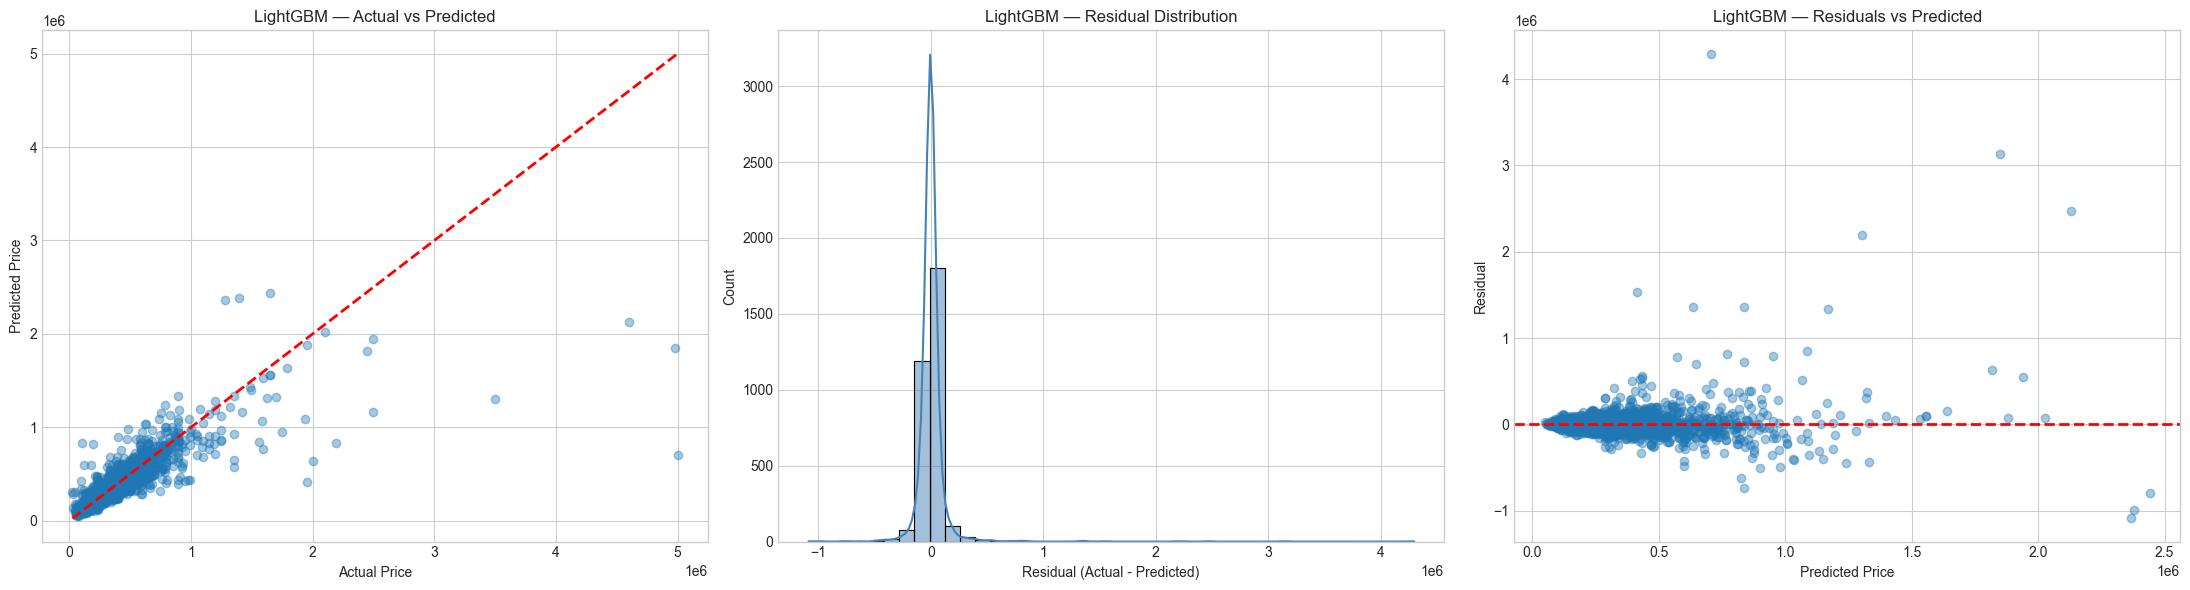

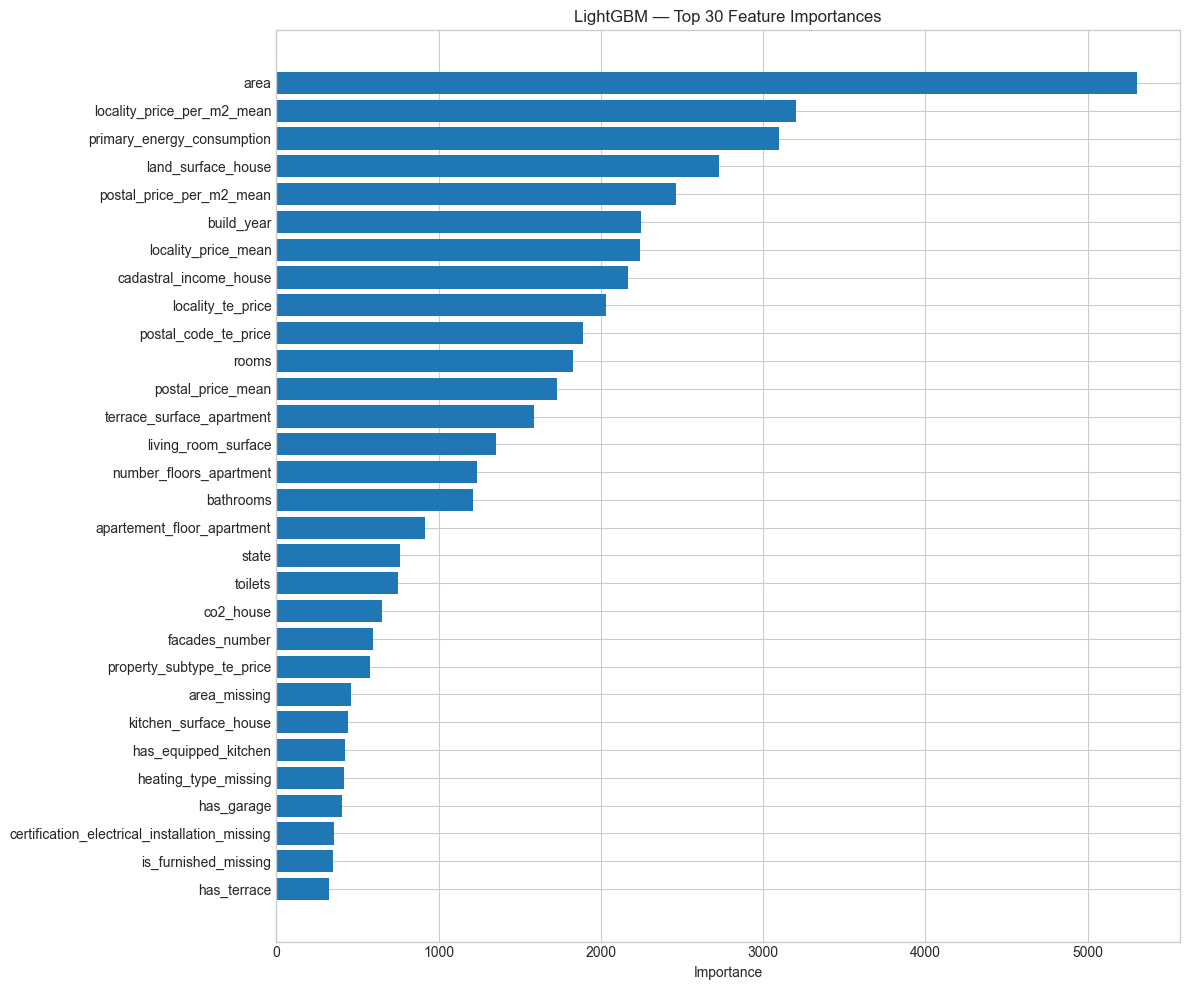

In [10]:
# ============================================================
# LIGHTGBM REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (same as RandomForest/XGBoost: numeric + TE features)
X_train_lgb, y_train_lgb = prepare_X_y(df_train, model_type="rf")
X_val_lgb,   y_val_lgb   = prepare_X_y(df_val,   model_type="rf")
X_test_lgb,  y_test_lgb  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (LightGBM):")
print("X_train:", X_train_lgb.shape, " y_train:", y_train_lgb.shape)
print("X_val  :", X_val_lgb.shape,   " y_val  :", y_val_lgb.shape)
print("X_test :", X_test_lgb.shape,  " y_test :", y_test_lgb.shape)

# ============================================================
# 1. Pipeline: Imputer + LightGBM Model
# ============================================================

lgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=64,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="regression"
        )),
    ]
)

# ============================================================
# 2. Train LightGBM
# ============================================================

lgb_pipeline.fit(X_train_lgb, y_train_lgb)

# ============================================================
# 3. Predict
# ============================================================

y_pred_train_lgb = lgb_pipeline.predict(X_train_lgb)
y_pred_val_lgb   = lgb_pipeline.predict(X_val_lgb)
y_pred_test_lgb  = lgb_pipeline.predict(X_test_lgb)

# ============================================================
# 4. Evaluation
# ============================================================

print("\n--- LightGBM (Train) ---")
evaluate_regression("LightGBM — Train", y_train_lgb, y_pred_train_lgb)

print("\n--- LightGBM (Validation) ---")
evaluate_regression("LightGBM — Validation", y_val_lgb, y_pred_val_lgb)

print("\n--- LightGBM (Test) ---")
evaluate_regression("LightGBM — Test", y_test_lgb, y_pred_test_lgb)

# ============================================================
# 5. Diagnostics on TEST
# ============================================================

plot_regression_diagnostics(
    y_test_lgb, 
    y_pred_test_lgb, 
    title_prefix="LightGBM"
)

# ============================================================
# 6. Feature Importances (Top 30)
# ============================================================

lgb_model = lgb_pipeline.named_steps["model"]
importances = lgb_model.feature_importances_

# Reuse your existing tree importance plotter (works perfectly)
plot_tree_importances(
    lgb_model,
    X_train_lgb.columns,
    top_n=30,
    title="LightGBM — Top 30 Feature Importances"
)


Shapes (CatBoost):
X_train: (15152, 68)  y_train: (15152,)
X_val  : (3247, 68)  y_val  : (3247,)
X_test : (3248, 68)  y_test : (3248,)

--- CatBoost (Train) ---
===== CatBoost — Train =====
MAE: 32,513.68
R² : 0.9605

--- CatBoost (Validation) ---
===== CatBoost — Validation =====
MAE: 58,549.80
R² : 0.7458

--- CatBoost (Test) ---
===== CatBoost — Test =====
MAE: 56,772.08
R² : 0.6609


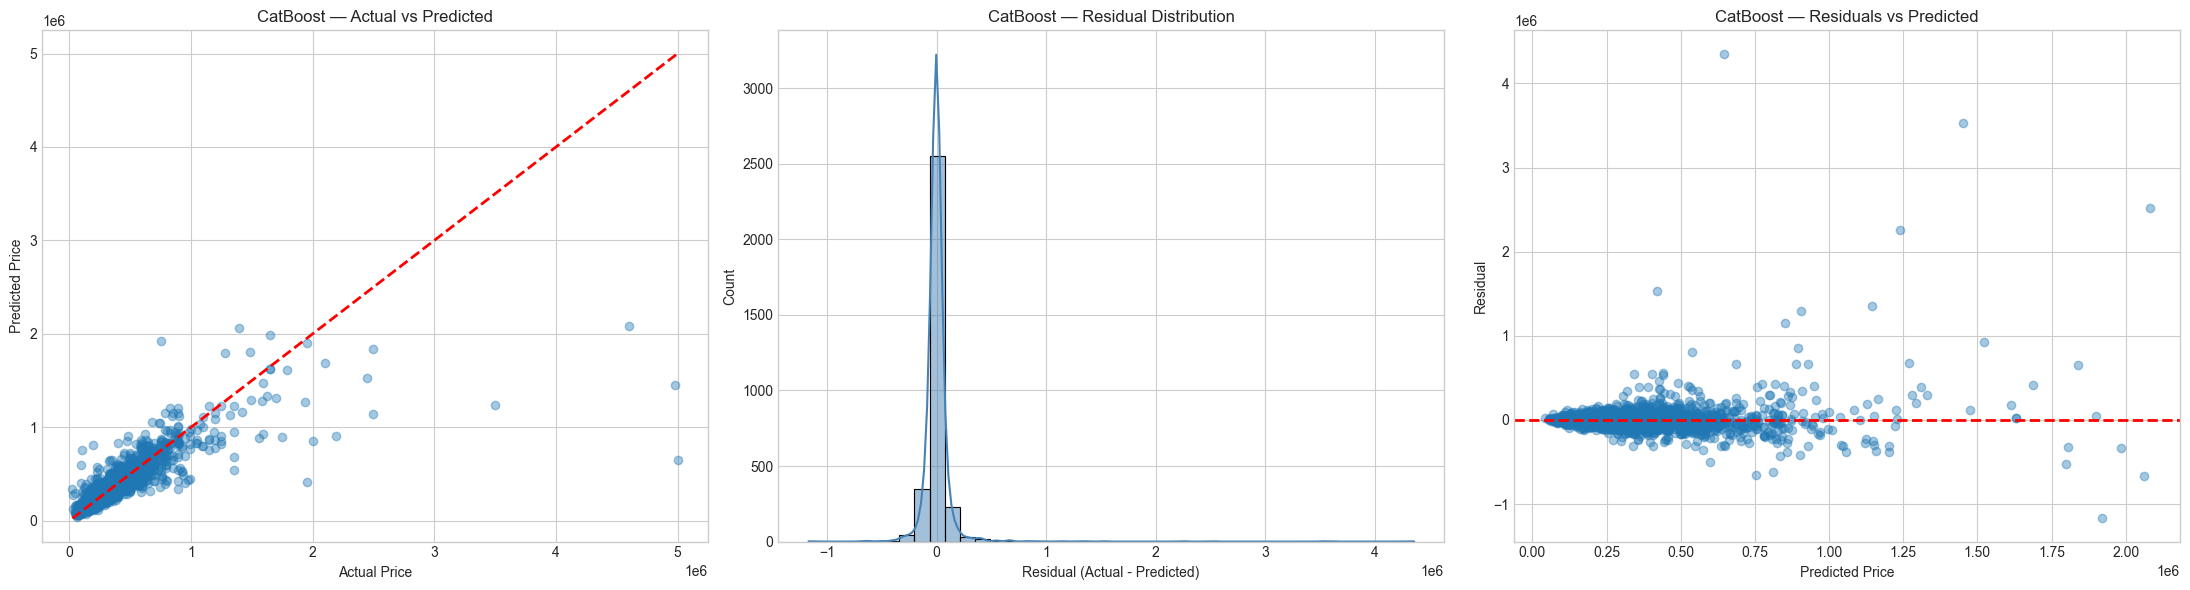

In [12]:
# ============================================================
# CATBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → model_type="rf")
X_train_cat, y_train_cat = prepare_X_y(df_train, model_type="rf")
X_val_cat,   y_val_cat   = prepare_X_y(df_val,   model_type="rf")
X_test_cat,  y_test_cat  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (CatBoost):")
print("X_train:", X_train_cat.shape, " y_train:", y_train_cat.shape)
print("X_val  :", X_val_cat.shape,   " y_val  :", y_val_cat.shape)
print("X_test :", X_test_cat.shape,  " y_test :", y_test_cat.shape)

# Pipeline: Imputer + CatBoost
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=8,
            loss_function="RMSE",
            random_seed=42,
            verbose=False
        ))
    ]
)

# Fit
cat_pipeline.fit(X_train_cat, y_train_cat)

# Predict
y_pred_train_cat = cat_pipeline.predict(X_train_cat)
y_pred_val_cat   = cat_pipeline.predict(X_val_cat)
y_pred_test_cat  = cat_pipeline.predict(X_test_cat)

# Evaluate
print("\n--- CatBoost (Train) ---")
evaluate_regression("CatBoost — Train", y_train_cat, y_pred_train_cat)

print("\n--- CatBoost (Validation) ---")
evaluate_regression("CatBoost — Validation", y_val_cat, y_pred_val_cat)

print("\n--- CatBoost (Test) ---")
evaluate_regression("CatBoost — Test", y_test_cat, y_pred_test_cat)

# Diagnostics (on TEST)
plot_regression_diagnostics(y_test_cat, y_pred_test_cat, title_prefix="CatBoost")


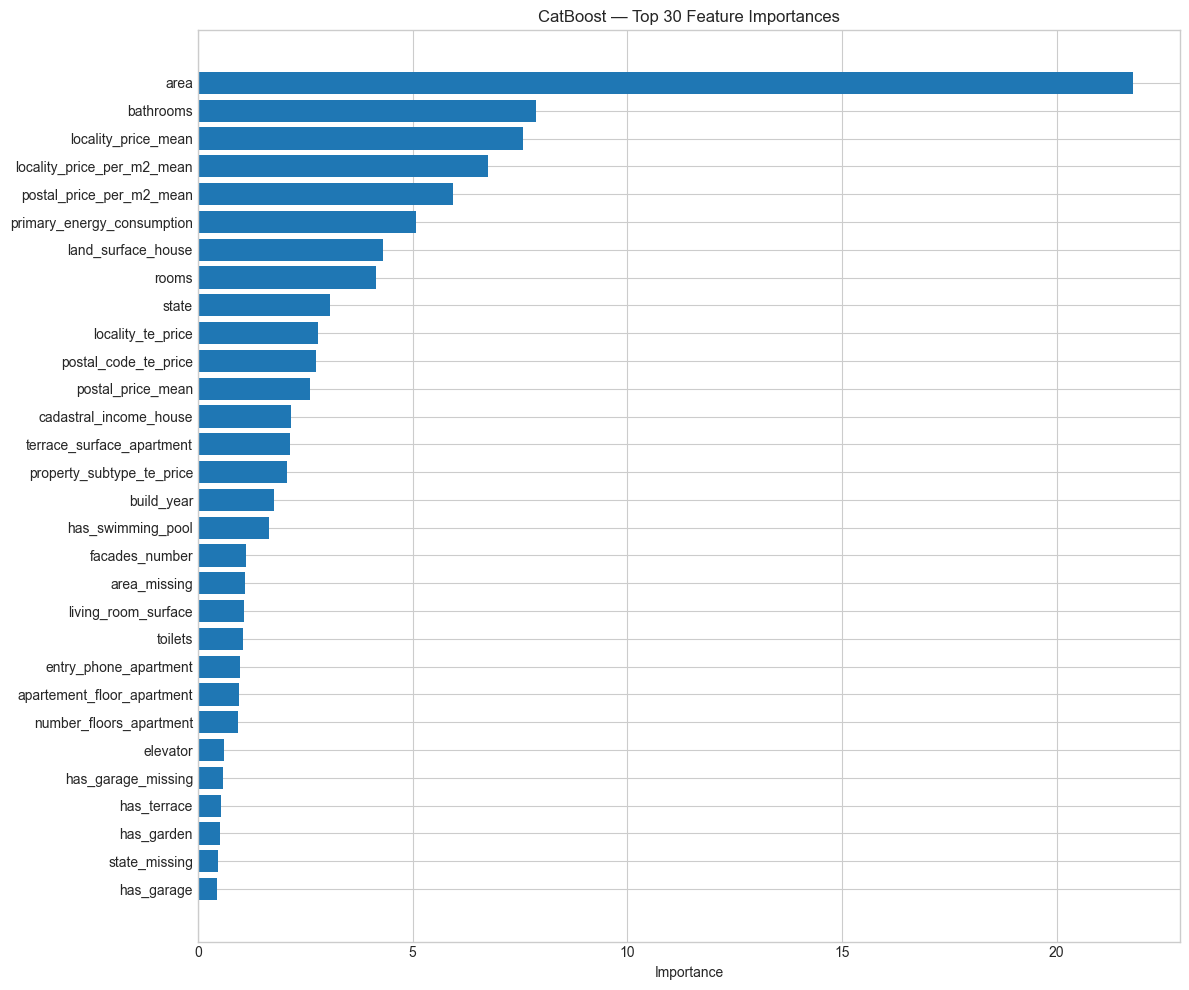

In [13]:
cat_model = cat_pipeline.named_steps["model"]

plot_tree_importances(
    cat_model,
    X_train_cat.columns,
    top_n=30,
    title="CatBoost — Top 30 Feature Importances"
)
